In [20]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F

In [59]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_device(device)

"""
加载数据
"""

data = pd.read_csv('filled_data.csv')

# 选择特征和标签
X = data[['SO2', 'NO', 'NO2', 'NOX', 'O3', 'temperature', 'wind_speed', 'relative_humidity', 'air_pressure']].values
y = data['PM2_5'].values

"""
数据预处理
"""

# 数据归一化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

# 创建DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [72]:
"""
定义模型
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 64)  # 9个输入特征
        self.bn1 = nn.BatchNorm1d(64)
        self.lstm1 = nn.LSTM(64, 64, batch_first=True)
        self.lstm2 = nn.LSTM(64, 64, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)  # 输出PM2.5的预测值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = x.unsqueeze(1)  # 将输入形状调整为 (batch_size, seq_len, input_size)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = x.squeeze(1)  # 移除 seq_len 维度
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc3(x)
        return x

# 示例化模型、优化器和损失函数
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [73]:
"""
训练模型
"""

train_losses = []
test_losses = []

epochs = 50
patience = 5  # 容忍度
best_test_loss = float('inf')  # 初始化为无穷大
patience_counter = 0  # 容忍计数器

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}')

    # 早停逻辑
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0  # 重置容忍计数器
    else:
        patience_counter += 1  # 增加容忍计数器

    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch + 1}.')
        break

Epoch 1/50, Train Loss: 503.2126225062779, Test Loss: 139.44537994949906
Epoch 2/50, Train Loss: 131.7931744464032, Test Loss: 119.04118564746997
Epoch 3/50, Train Loss: 126.53529660821182, Test Loss: 115.85100736264829
Epoch 4/50, Train Loss: 122.42405226500446, Test Loss: 113.7440510502568
Epoch 5/50, Train Loss: 120.7913468242355, Test Loss: 111.2488232365361
Epoch 6/50, Train Loss: 120.22490258296479, Test Loss: 112.37849550600406
Epoch 7/50, Train Loss: 117.55523700041762, Test Loss: 111.07072544804326
Epoch 8/50, Train Loss: 117.07578615885718, Test Loss: 109.1701820090965
Epoch 9/50, Train Loss: 115.0259087656336, Test Loss: 107.38801973130968
Epoch 10/50, Train Loss: 112.47444408324742, Test Loss: 106.17760111490885
Epoch 11/50, Train Loss: 112.44204952544317, Test Loss: 104.69158904464156
Epoch 12/50, Train Loss: 111.83805268239887, Test Loss: 104.79266292430736
Epoch 13/50, Train Loss: 109.75645395112613, Test Loss: 104.75519047489873
Epoch 14/50, Train Loss: 107.491573312508

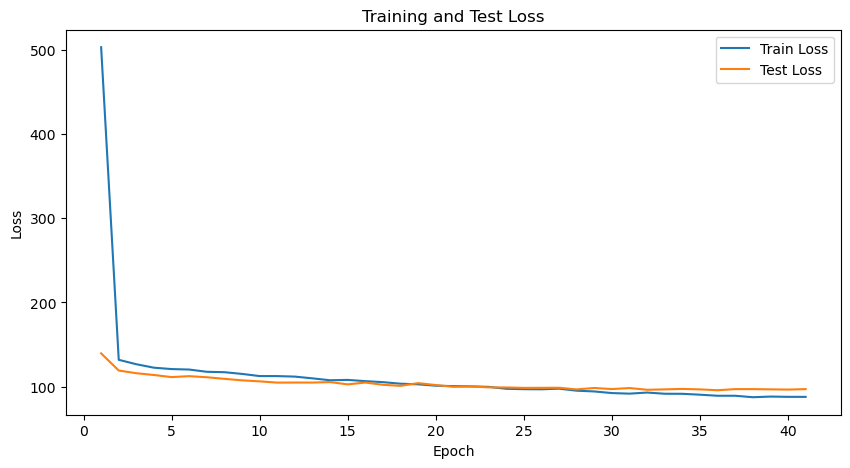

In [74]:
import matplotlib.pyplot as plt

# 绘制训练集和测试集的损失曲线
plt.figure(figsize=(10, 5))
# 使用 len(train_losses) 和 len(test_losses) 来确保绘制所有记录的损失
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

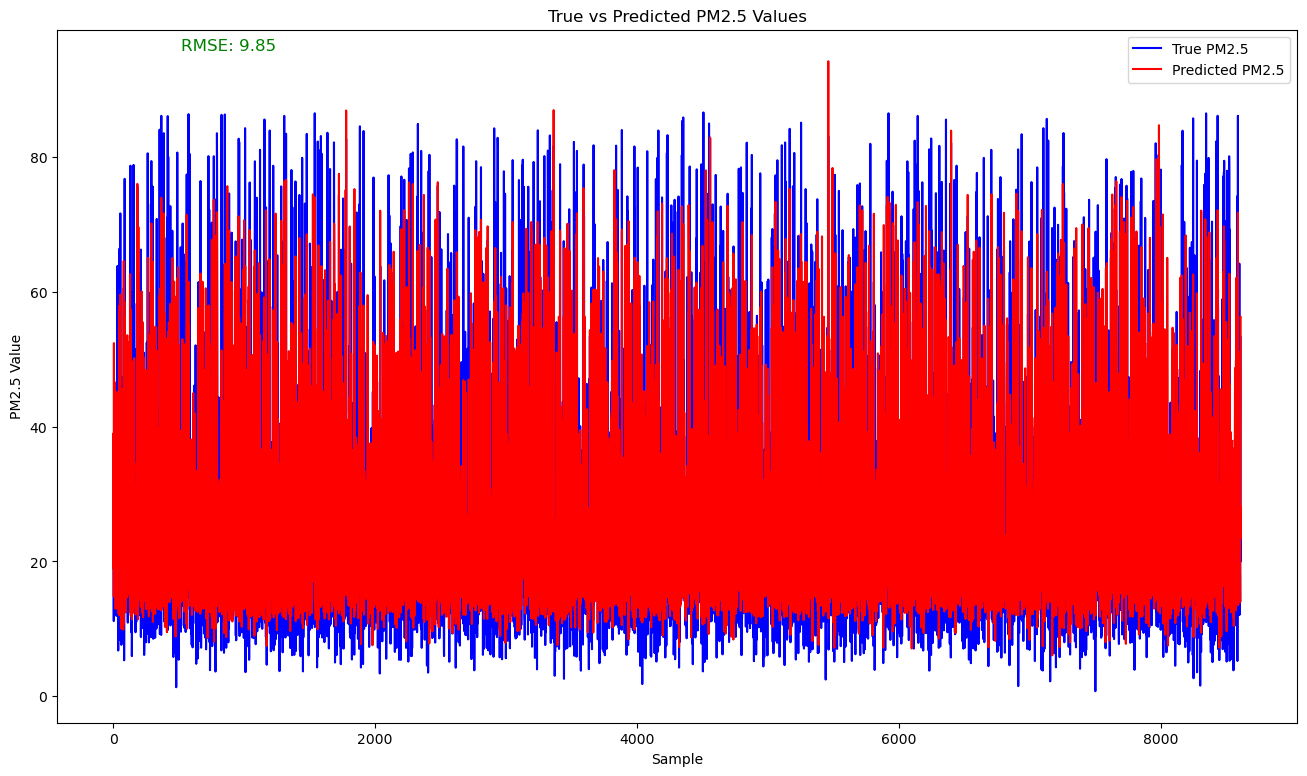

In [75]:
"""
测试模型
"""
model.eval()
true_pm25 = []
predicted_pm25 = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        true_pm25.extend(labels.numpy())
        predicted_pm25.extend(outputs.numpy())

# 计算均方根误差（RMSE）
rmse = np.sqrt(np.mean((np.array(true_pm25) - np.array(predicted_pm25))**2))

# 绘制真实值和预测值的图像
plt.figure(figsize=(16, 9))
plt.plot(true_pm25, label='True PM2.5', color='blue')
plt.plot(predicted_pm25, label='Predicted PM2.5', color='red')
plt.xlabel('Sample')
plt.ylabel('PM2.5 Value')
plt.title('True vs Predicted PM2.5 Values')
plt.text(0.1, 0.97, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, fontsize=12, color='green')
plt.legend()
plt.show()